<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/automatic_image_captioning/model_deployment_prep_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Aug 20 review with prof - integrate, github
# Properly commented - prepare in a blog format - end to end
# Reference doc
# Bleu, 

In [50]:


from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


# LSTM architecture
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
#from keras.layers.merge import add
from keras.layers import add
from keras.layers import Layer
import keras.backend as K
from keras.models import Model

# from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

from keras.preprocessing import image
import numpy as np
from pickle import dump, load
import matplotlib.pyplot as plt

import tensorflow.keras.utils as tf_utils
# import load_img, img_to_array

### fold 1

In [51]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [52]:
vocab_size = 1652
embedding_dim = 200
max_length=34


pkl_wordtoix_file = "/content/wordtoix.pkl"
pkl_ixtoword_file = "/content/ixtoword.pkl"

with open(pkl_wordtoix_file, "rb") as encoded_wordtoix_pickle:
    wordtoix = load(encoded_wordtoix_pickle)


with open(pkl_ixtoword_file, "rb") as encoded_ixtoword_pickle:
    ixtoword = load(encoded_ixtoword_pickle)


In [53]:
HYP_ENABLE_ATTENTION = True
if HYP_ENABLE_ATTENTION:

    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    inputs2 = Input(shape=(34,))
    # inputs=Input((features,))
    #embedding_dim - replace at output_dim
    # x=Embedding(input_dim=vocab_size, output_dim=200, input_length=features, embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)
    x = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762

    #se3 = LSTM(256)(se2)
    att_in=LSTM(256,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)

    att_out=attention()(att_in)

    decoder1 = add([fe2, att_out])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [54]:
#LSTM Model

lstm_model.load_weights('/content/model_30.h5') 

### Fold 2

In [55]:
HYP_ENCODER_MODEL = "RESNET50"


In [56]:
if HYP_ENCODER_MODEL == "RESNET50":
    model = ResNet50(weights='imagenet')
    
if HYP_ENCODER_MODEL == "RESNET50":
    # Create a new model, by removing the last layer (output layer) from the ResNet50
    model_new = Model(model.input, model.layers[-2].output)

In [62]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model(To be replaced with ResNet50)
    # from keras.preprocessing import image

    # img = image.load_img(image_path, target_size=(299, 299))
    # img = image.load_img(image_path, target_size=(224, 224))
    img = tf_utils.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    # x = image.img_to_array(img)
    x = tf_utils.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    # from keras.applications.inception_v3 import preprocess_input
    # from keras.applications.resnet50 import preprocess_input 
    x = preprocess_input(x)
    return x

In [63]:
# Function to encode a given image into a vector of size (2048, )
# 

def encode(image):
    """
    return: a 2048 vector of an image (Feature vector)
    """
    image = preprocess(image) # preprocess the image - user defined method
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [64]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = lstm_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

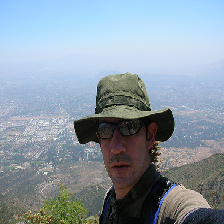

In [65]:
input_image = "/content/2090339522_d30d2436f9.jpg"
tf_utils.load_img(input_image, target_size=(224, 224))

In [66]:
#image = encoding_test[image_name].reshape((1,2048))
image1 = encode(input_image).reshape((1,2048))
# x=plt.imread(images+pic)
# plt.imshow(x)
# plt.show()
print("Greedy:",greedySearch(image1))

1/1 [==============================] - 1s 1s/step
Greedy: man in sunglasses and sunglasses and sunglasses and hat and hat and hat and hat and hat walking on the mountains


In [ ]:

# structure
# 